In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [3]:
net = 'stepnet'#'highd_inputs'#'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter
from tools_lnd import make_axes, same_stim_trial, comp_eig_decomp, name_best_ckpt, plot_FP, plot_N
from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
from tools_lnd import make_h_and_Jac, make_Jac_x, gen_trials_from_model_dir, gen_X_from_model_dir_epoch, gen_X_from_model_dir

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


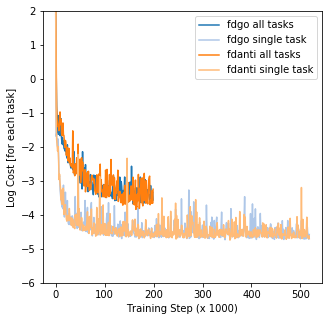

In [4]:
rule = 'contextdelaydm1'
task_set = ['fdgo','fdanti']
model_n = 0
fig = plt.figure(figsize=(5, 5))
which_net = 'l2w0001'

for r in range(len(task_set)):
    rule = task_set[r]

    dir_specific_single = 'crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/'
    dir_specific_all = 'crystals/softplus/' + which_net
    m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
    m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
    
    cmap = plt.get_cmap('tab20')
    c_ind = 0
    for m_ind in range(len([m_all, m_single])):
        m = [m_all, m_single][m_ind]
        m_label = rule+[' all tasks', ' single task'][m_ind]
        
        fname = os.path.join(m, 'log.json')

        with open(fname, 'r') as f:
            log_all = json.load(f)
            ax = fig.add_subplot(1,1,1)
            x = np.log(log_all['cost_'+rule])
            plt.plot(x,'-',c = cmap((2*r+m_ind)/20),label = m_label)

    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])

plt.legend()
plt.show()    

In [5]:
from tools_lnd import eigenspectrum_axes

def make_eig_plot(ax):
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    
    ax.plot(xs, ys,':k',linewidth = 1)
    ax.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.6,1.3))
    plt.ylim((-.25,.25))
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax)
    ax.set_aspect('equal') 

In [6]:
task_list = ['fdgo',
 'delaygo',
 'fdanti',
 'delayanti',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

stim_list = [0,
 0,
 180,
 180,
 180,
 180,
 180,
 180,
 180,
 0,
 180,
 18,
 198]

In [7]:
task_list = ['fdgo','fdanti']

stim_list = [0,180]

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10


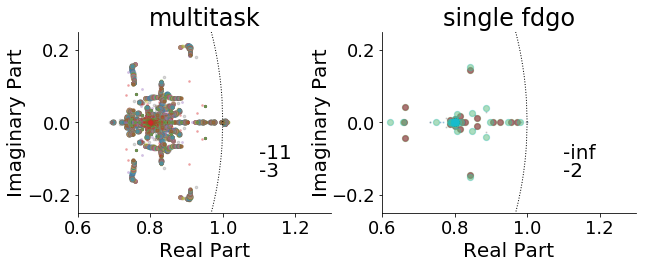

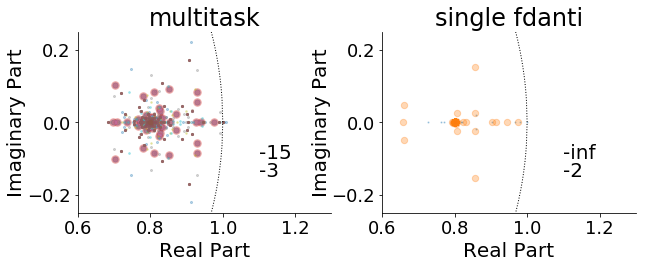

In [8]:
from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
plt.rcParams.update({'font.size': 20})

#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'
for ri in range(len(task_list)):
    rule = task_list[ri]
    ind_stim_loc = stim_list[ri]
    
#     dir_specific_single = os.path.join('crystals/softplus/single_tasks',which_net,rule)
    dir_specific_single = 'crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/'
    m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
    epoch = 'stim1'
    
    fig = plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1,2,1)
    filename = os.path.join(m_all,fp_file,rule,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
    fp_struct = np.load(filename)
    fp_sort = np.argsort(np.log10(fp_struct['qstar']))
    log10q = np.log10(fp_struct['qstar'])
    
    fp_num = fp_sort[log10q[fp_sort]<-8]
    J_xstar = fp_struct['J_xstar']#[fp_num,:,:]

    for fp_num in range(np.shape(J_xstar)[0]):
        evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
        ax1.plot(evals.real,evals.imag,'.',markersize = -log10q[fp_num],alpha = .3)
        
    plt.text(1.1,-.1,"{:.0f}".format(np.min(log10q)))
    plt.text(1.1,-.15,"{:.0f}".format(np.max(log10q)))
    make_eig_plot(ax1)
    plt.title('multitask')

    ax2 = plt.subplot(1,2,2)
    filename = os.path.join(m_single,fp_file,rule,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
    fp_struct = np.load(filename)
    fp_sort = np.argsort(np.log10(fp_struct['qstar']))
    log10q = np.log10(fp_struct['qstar'])
    
    log10q_keep = fp_sort[log10q[fp_sort]<-8]
    J_xstar = fp_struct['J_xstar']#[fp_num,:,:]

    for fp_num in range(np.shape(J_xstar)[0]):
        evals, _ = LA.eig(J_xstar[fp_num,:,:]) 
        ax2.plot(evals.real,evals.imag,'.',markersize = -log10q[fp_num], alpha = .3)
             
    plt.text(1.1,-.1,"{:.0f}".format(np.min(log10q)))
    plt.text(1.1,-.15,"{:.0f}".format(np.max(log10q)))
    make_eig_plot(ax2)
    plt.title('single '+rule)
    plt.show()

In [18]:
## from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
plt.rcParams.update({'font.size': 20})

#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'
model_n = 0
    
# dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
dir_specific_single = 'crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/'
m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

r1 = 'fdgo'
r2 = 'fdanti'
epoch = 'stim1'
D_r1 = make_axes(m_all,r1,epoch)
D_r2 = make_axes(m_all,r2,epoch)
ind_stim_loc = 0

model = Model(m_all)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    
    trial_r1 = generate_trials(r1, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_r1, hparams)
    h_tf_r1 = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    X1 = np.transpose(h_tf_r1,(1,0,2))
    
    trial_r2 = same_stim_trial(trial_r1,3)
    feed_dict = tools.gen_feed_dict(model, trial_r2, hparams)
    h_tf_r2 = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    X2 = np.transpose(h_tf_r2,(1,0,2))

fp_file = 'tf_fixed_pts_all_init'
f = os.path.join(m_all,fp_file,r1,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
fp_struct1 = np.load(f)
eig_decomps1 = comp_eig_decomp(fp_struct1['J_xstar'])

f = os.path.join(m_all,fp_file,r2,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
fp_struct2 = np.load(f)
eig_decomps2 = comp_eig_decomp(fp_struct2['J_xstar'])

stim_inds = range(trial_r1.epochs['stim1'][0],trial_r1.epochs['stim1'][1])
trial_set = range(0,80,10)
X1_stim = X1[:, stim_inds,:]
X2_stim = X2[:, stim_inds,:]

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fr

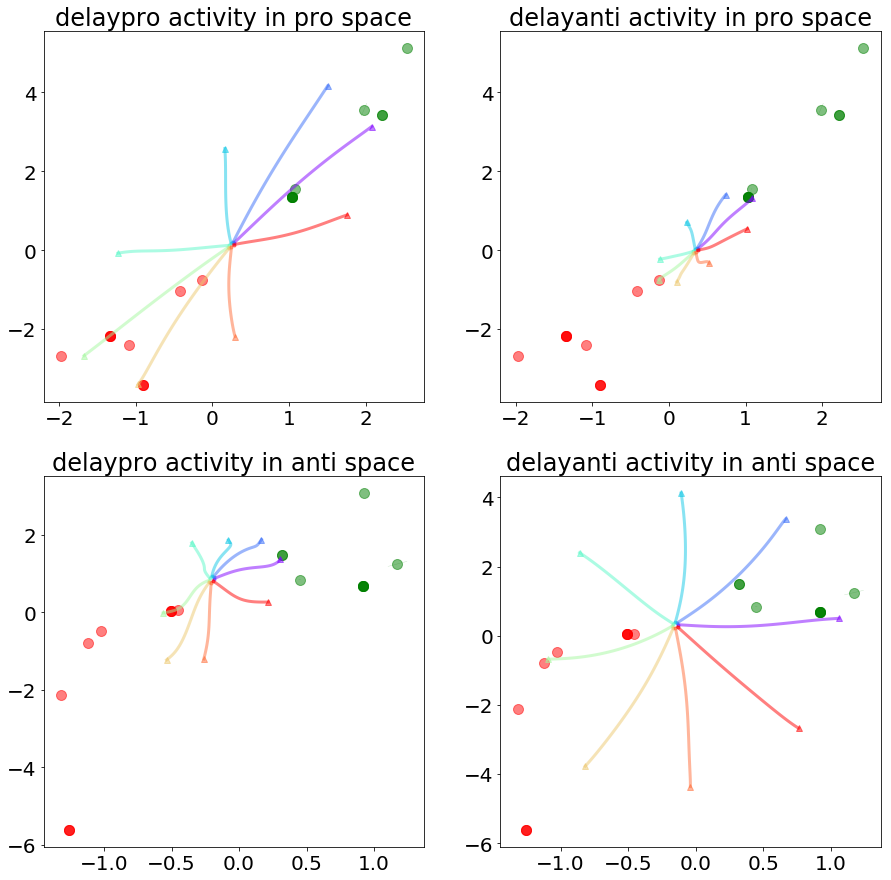

In [19]:
cmap = plt.get_cmap('rainbow')

fig = plt.figure(figsize=(15, 15))
D_use = D_r1
ax = plt.subplot(2,2,1)
plot_FP(fp_struct1['xstar'], D_use.T, eig_decomps1,c = 'g')
plot_FP(fp_struct2['xstar'], D_use.T, eig_decomps2,c = 'r')
plot_N(X1_stim[trial_set,:,:], D_use.T, trial_set, alpha = .5, linewidth = 3)
plt.title('delaypro activity in pro space')

ax = plt.subplot(2,2,2)
plot_FP(fp_struct1['xstar'], D_use.T, eig_decomps1,c = 'g')
plot_FP(fp_struct2['xstar'], D_use.T, eig_decomps2,c = 'r')
plot_N(X2_stim[trial_set,:,:], D_use.T, trial_set, alpha = .5, linewidth = 3)
plt.title('delayanti activity in pro space')

D_use = D_r2
ax = plt.subplot(2,2,3)
plot_FP(fp_struct1['xstar'], D_use.T, eig_decomps1,c = 'g')
plot_FP(fp_struct2['xstar'], D_use.T, eig_decomps2,c = 'r')
plot_N(X1_stim[trial_set,:,:], D_use.T, trial_set, alpha = .5, linewidth = 3)
plt.title('delaypro activity in anti space')

ax = plt.subplot(2,2,4)
plot_FP(fp_struct1['xstar'], D_use.T, eig_decomps1,c = 'g')
plot_FP(fp_struct2['xstar'], D_use.T, eig_decomps2,c = 'r')
plot_N(X2_stim[trial_set,:,:], D_use.T, trial_set, alpha = .5, linewidth = 3)
plt.title('delayanti activity in anti space')
# plt.legend('Pro FPs','Anti FPs')
plt.show()

In [20]:
model_n = 0   
which_net = 'l2w0001'
# dir_specific_all = 'crystals/softplus/' + which_net 
dir_specific_all = 'crystals/softplus/two_tasks/l2w0001_fdgo_fdanti'
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


In [21]:
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


In [22]:
def get_perf(y_hat, y_loc):
    """Get performance.

    Args:
      y_hat: Actual output. Numpy array (Time, Batch, Unit)
      y_loc: Target output location (-1 for fixation).
        Numpy array (Time, Batch)

    Returns:
      perf: Numpy array (Batch,)
    """
    if len(y_hat.shape) != 3:
        raise ValueError('y_hat must have shape (Time, Batch, Unit)')
    # Only look at last time points

    y_loc = y_loc[-1]
    y_hat = y_hat[-1]

    # Fixation and location of y_hat
    y_hat_fix = y_hat[..., 0]
    y_hat_loc = popvec(y_hat[..., 1:])

    # Fixating? Correctly saccading?
    fixating = y_hat_fix > 0.5

    original_dist = y_loc - y_hat_loc
    dist = np.minimum(abs(original_dist), 2*np.pi-abs(original_dist))
    corr_loc = dist < 0.1*np.pi

    # Should fixate?
    should_fix = y_loc < 0

    # performance
    perf = should_fix * fixating + (1-should_fix) * corr_loc * (1-fixating)
    return perf

In [23]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

pro_tasks = {'set_name':'pro','set':['fdgo', 'delaygo', 'delaydm1', 'delaydm2', 'contextdelaydm1', 
             'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmcgo']}

anti_tasks = {'set_name':'anti','set':['fdanti', 'delayanti']}

react_tasks = {'set_name':'reactgo','set':['reactgo',]}
fdgo_tasks = {'set_name':'delaypro','set':['fdgo',]}
fdanti_tasks = {'set_name':'delayanti','set':['fdanti',]}

In [24]:
def plot_initXtasks(rule_ic_set, rule_in_set, c):

    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        b = 0 #trial number for now
        h0 = h_all[rule_ic][t_ind,b,:]

        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            h_t = np.empty((n_steps,n_rnn))
            y_hat = np.empty((n_steps,n_output))
            x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
            h = h0
            for ti in range(t_end-t_start):
                h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                h_t[ti,:] = h
                y_hat[ti,:] = out_affine(params, h_t[ti,:])

            for out_ind in range(n_output):
                ax = plt.subplot(1,3,out_ind+1)
                plt.plot(y_hat[:,out_ind],c,label = rule_ic + ' ic', alpha = .2)
                plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':'+c,label = rule_in + ' target',linewidth = 2)
                plt.ylim((-1.5,1.5))
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                if out_ind == 0:
                    plt.title(rule_ic_set['set_name']+' ic, '+ rule_in_set['set_name']+ ' input')
                else:
                    ax.spines['left'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.get_xaxis().set_ticks([])
                    ax.get_yaxis().set_ticks([])

    

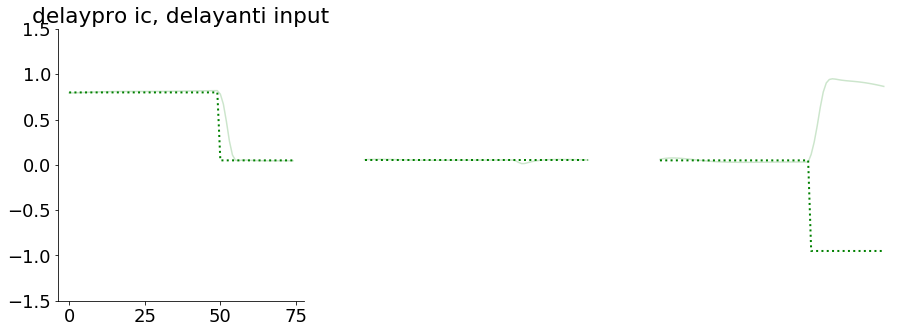

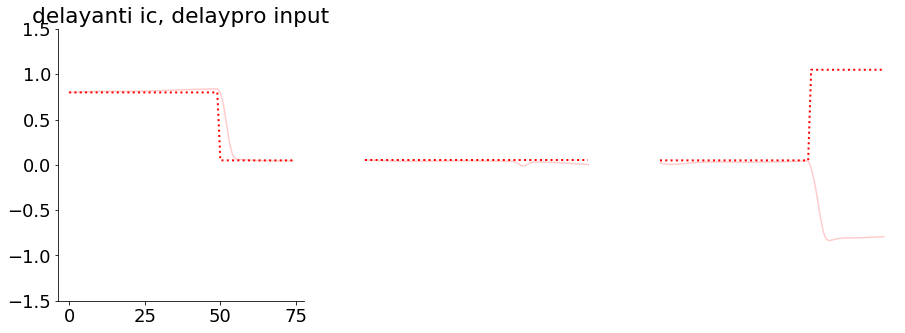

In [25]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(fdgo_tasks, fdanti_tasks, 'g')
plt.show()

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(fdanti_tasks, fdgo_tasks, 'r')

KeyError: 'delaygo'

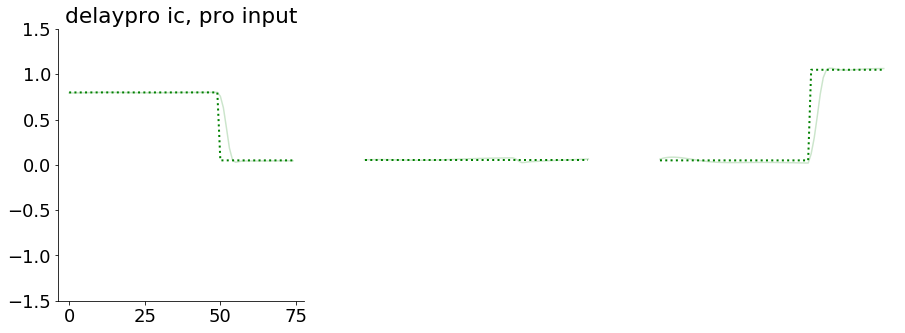

In [17]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(fdgo_tasks, pro_tasks, 'g')
plt.show()

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(fdgo_tasks, anti_tasks, 'r')
plt.show()

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(react_tasks, pro_tasks, 'g')
plt.show()

fig = plt.figure(figsize=(15, 5))
plot_initXtasks(react_tasks, anti_tasks, 'r')
plt.show()

In [ ]:
from network import get_perf

def quant_perf(rule_ic_set, rule_in_set):
    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        
        ri = 0
        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            n_trials = trial_all[rule_in].x.shape[1]
            
            y_locs = trial_all[rule_in].y_loc[t_start:,:]
            y_hat = np.empty((n_steps,n_trials,n_output))
            
            for b in range(n_trials):
                h0 = h_all[rule_ic][t_ind,0,:]
                h_t = np.empty((n_steps,n_rnn))
                x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
                h = h0
                for ti in range(t_end-t_start):
                    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                    h_t[ti,:] = h
                    y_hat[ti,b,:] = out_affine(params, h_t[ti,:])

            perf = get_perf(y_hat, y_locs)
            plt.plot(ri,np.mean(perf),'.k')
            ri+=1
            
        plt.xticks(range(len(rule_in_set['set'])), rule_in_set['set'],rotation = 45)
        plt.ylim((0,1.1))
        plt.xlim((-.5,ri-.5))
        plt.title(rule_ic + ' initial conditions')

In [ ]:
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'random',noise_on = False)

quant_perf(fdgo_tasks, pro_tasks)
plt.show()

quant_perf(fdgo_tasks, anti_tasks)
plt.show()

quant_perf(react_tasks, pro_tasks)
plt.show()

quant_perf(react_tasks, anti_tasks)
plt.show()

In [31]:
def make_FP_pcs(f,n_fps = 4):
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    
    kmeans = KMeans(n_clusters=np.min((n_fps,np.shape(fp_struct['xstar'])[0])), random_state=0).fit(sorted_fps)
    _,fp_inds = np.unique(kmeans.labels_,return_index=True)

    pca = PCA(n_components = 2)
    fp_pca = pca.fit_transform(sorted_fps[fp_inds,:])
    D_pca = pca.components_.T
    D_use = D_pca
    
    return D_pca, sorted_fps, fp_inds

def plot_FP_jitter(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.01,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 50):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

#         for rule in rule_set:
#             trial = generate_trials(rule, hparams, mode='test',noise_on=False)
#             feed_dict = tools.gen_feed_dict(model, trial, hparams)
#             h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
#             T,S,N = np.shape(h_tf)
#             T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

#             for s in range(0,S,int(S/8)):

#                 c_inds = trial.y_loc[-1,:]
#                 c = cmap(c_inds[s]/(2*np.pi))

#                 X_trial = np.dot(h_tf[T_inds,s,:],D_use)
#                 plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,markersize = 1)

        N = np.shape(sorted_fps)[1]
        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T_inds = get_T_inds(trial,fp_epoch)

        c_inds = trial.y_loc[-1,:]
        c = cmap(c_inds[t_num]/(2*np.pi))

        X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = 5)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = 5)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = 5,markersize = 1)

    for fp_ind in fp_inds:

        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        for jit in range(n_jit):
            h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^r',linewidth = .1,alpha = .1)
            plt.plot(jitter[:,0],jitter[:,1],'-r',linewidth = .1)
         
        fp = np.dot(sorted_fps[fp_ind,:],D_use)
        plt.plot(fp[0],fp[1],'xr',linewidth = 5,markersize = 10)

#         h0 = sorted_fps[fp_ind,:]
#         h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
#         jitter = np.dot(h_t,D_use)
#         plt.plot(jitter[-1,0],jitter[-1,1],'^k')
#         plt.plot(jitter[:,0],jitter[:,1],'-k')
#         plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 5,markersize = 10)

#     h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], alpha)
#     jitter = np.dot(h_t,D_use)
#     plt.plot(jitter[-1,0],jitter[-1,1],'^k',c = c)
#     plt.plot(jitter[:,0],jitter[:,1],':k',c = c)
#     plt.plot(jitter[0,0],jitter[0,1],'xk',c = c,linewidth = 5,markersize = 10)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(rule_master)
    
def plot_N_jitter(m,D_use,rule,fp_epoch,rand_step_coef = 0.01,n_steps = 70,n_jit = 50,
                   lw = 3,al = .6,linestyle = '-',mode = 'test', batch_size = 100):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        trial = generate_trials(rule, hparams, mode=mode,noise_on=False, batch_size = 100,delay_fac = 1)
        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
                                
        if mode=='test':
            trial_set = range(0,S,int(S/8))
        else:
            trial_set = range(0,S,int(S/50))

        for s in trial_set:

            c_inds = s/np.max(trial_set)#trial.y_loc[-1,s]/(2*np.pi)
            c = cmap(c_inds)

            X_trial = np.dot(h_tf[T_inds,s,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,markersize = 1)

            x_t = np.matlib.repmat(trial.x[T_inds[1],s,:],n_steps,1)
            for jit in range(n_jit):
                h0 = h_tf[T_inds[0]-1,s,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = .5,alpha = .5)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fr

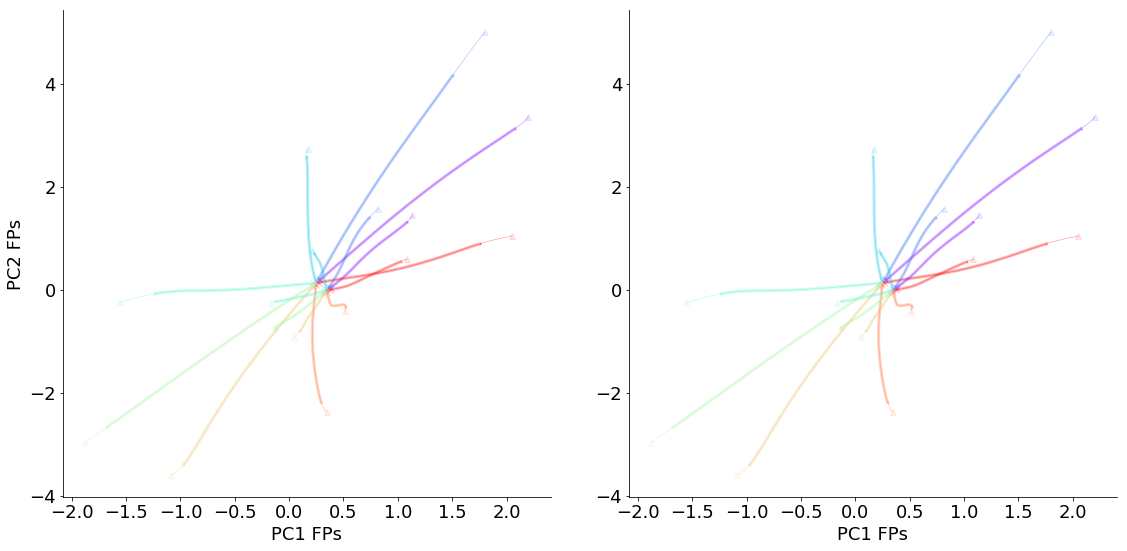

In [33]:
rule_set = ['fdgo','fdanti']
    
t_num = 0
n_fps = 30

if 'h' in which_net:
    rand_step_coef = 0.01
else:
    rand_step_coef = 0.1

fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='white')

ind_stim_loc = 0
fp_epoch = 'stim1'
# fp_file = 'tf_fixed_pts_all_init'
# f = os.path.join(m_all,fp_file,rule_master,fp_epoch+'_'+str(round(ind_stim_loc,2))+'.npz')

ax1 = plt.subplot(1,2,1)
rule_master = rule_set[0]
f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_master,fp_epoch+'_'+str(t_num)+'.0.npz')
# D_reactgo, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = n_fps)
D_use = make_axes(m_all,rule_master,fp_epoch)

if fp_epoch=='go1':
    w_in, b_in, w_out, b_out = get_model_params(m_all)
    D_use = w_out[:,1:]
    xlab = 'Output ' + r' $\cos{\theta}$'
    ylab = 'Output ' + r' $\sin{\theta}$'
    task_set = rule_set
else:
    xlab = 'PC1 FPs'
    ylab = 'PC2 FPs'
    task_set = task_list
    
# D_use = make_axes(m_all,rule_master,fp_epoch)

for rule in rule_set:
    plot_N_jitter(m_all,D_use,rule,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
# plot_FP_jitter(m_all,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,[rule_master,],
#                rand_step_coef = rand_step_coef,linestyle = ':',n_steps = 50)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel(xlab)
plt.ylabel(ylab)

ax2 = plt.subplot(1,2,2)
rule_master = rule_set[1]
f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_master,fp_epoch+'_'+str(180)+'.0.npz')
# _, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = n_fps)

for rule in rule_set:
    plot_N_jitter(m_all,D_use,rule,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
# plot_FP_jitter(m_all,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,[rule_master,],
#                rand_step_coef = rand_step_coef,linestyle = ':',n_steps = 50)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.xlabel(xlab)
plt.ylabel(' ')

figpath = os.path.join(m_all,'phantom FPs','fp_jitter')
figname = rule_set[0]+'_'+rule_set[1]+'_'+fp_epoch+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [34]:
def plot_jitter_at_loc(m, rule_ic, rule_in, D_use, epoch, t_num, rand_step_coef = 0, n_steps = 50, n_jit = 50):
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_ic, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
    jit_locs = h_tf[trial.epochs['fix1'][1]-1,:,:]
    loc_inds = np.shape(jit_locs)[0]
    print(loc_inds)
    N = np.shape(h_tf)[2]
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0
        trial = generate_trials(rule_in, hparams, mode='test', noise_on=False, batch_size = 100,delay_fac = 1)
     
    for ii in range(loc_inds):
        
        jit_loc = jit_locs[ii,:]

        T_inds = get_T_inds(trial, epoch)
        x_t = np.matlib.repmat(trial.x[T_inds[1]-1,t_num,:],n_steps,1)
        
        for jit in range(n_jit):
            h0 = jit_loc + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
            plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
80
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /

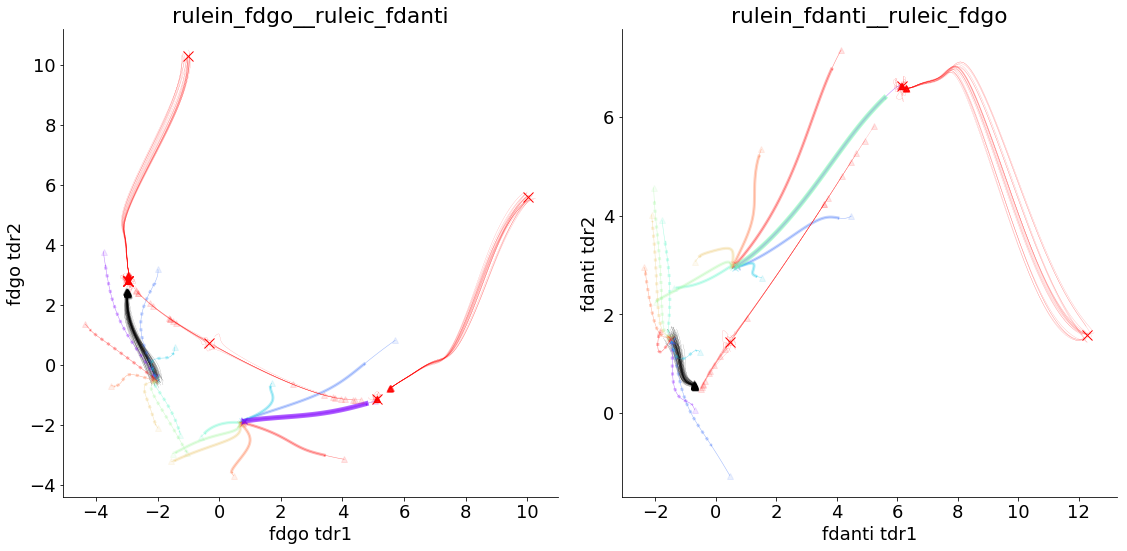

In [35]:
rule_set = ['fdgo','fdanti']
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='white')

fp_epoch = 'stim1'
opp = [1,0]
fp_t_num = [0, 180]
ind_stim_loc = fp_t_num[0]

if ind_stim_loc == 0:
    t_num = 0
else:
    t_num = int(360/ind_stim_loc)
    
n_fps = 50

if 'h' in which_net:
    rand_step_coef = 0.01
else:
    rand_step_coef = 0.1

for ri in range(len(rule_set)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = rule_set[ri]
    rule_ic = rule_set[opp[ri]]
    D_use = make_axes(m_all,rule_in,fp_epoch)
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = n_fps)
    
    pca = PCA(n_components = 2,whiten = True)
    X_pca = pca.fit_transform(sorted_fps[fp_inds,:])
    D_use = pca.components_.T
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = rand_step_coef, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = rand_step_coef, linestyle ='-', n_steps = 100, n_jit = 20)
    
    tit = 'rulein_'+ rule_in + '__ruleic_'+ rule_ic
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel(rule_in+ ' tdr1')
    plt.ylabel(rule_in+ ' tdr2')
    
figpath = os.path.join(m,'initXtask',task_list[0]+'_'+task_list[1])
figname = task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

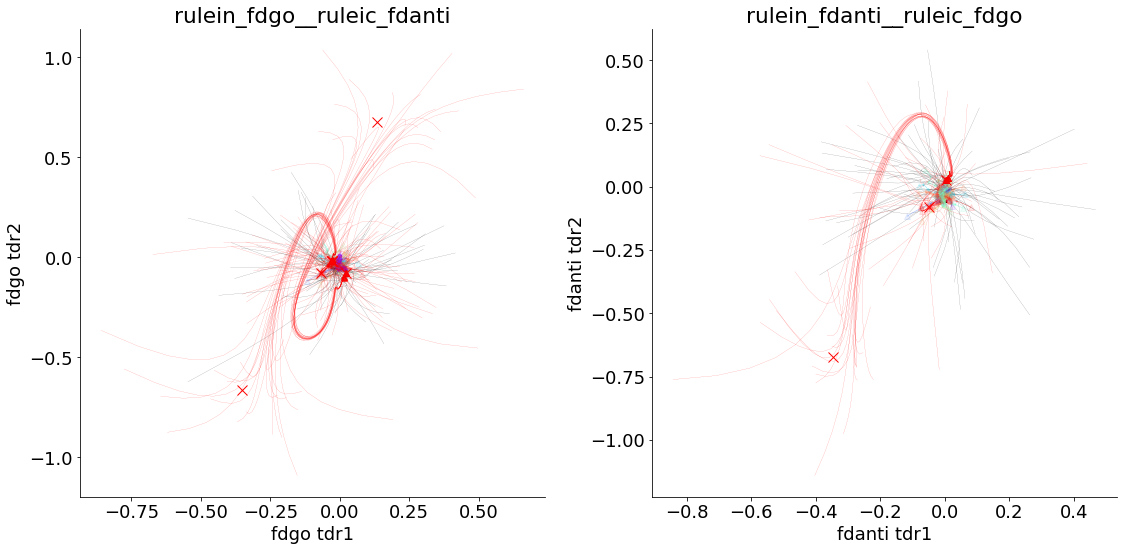

In [36]:
rule_set = ['fdgo','fdanti']
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='white')

fp_epoch = 'stim1'
opp = [1,0]
offset = 0
fp_t_num = [offset, 180+offset]

if ind_stim_loc == fp_t_num[0]:
    t_num = 0
else:
    t_num = int(360/ind_stim_loc)
    
n_fps = 50

if 'h' in which_net:
    rand_step_coef = 0.01
else:
    rand_step_coef = 0.1

for ri in range(len(rule_set)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = rule_set[ri]
    rule_ic = rule_set[opp[ri]]
#     D_use = make_axes(m_all,rule_in,fp_epoch)
    w_in, b_in, w_out, b_out = get_model_params(m_all)
    D_use = w_out[:,1:]
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = rand_step_coef, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = n_fps)
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = rand_step_coef,linestyle = '-',n_steps = 100,n_jit = 20)
    
    tit = 'rulein_'+ rule_in + '__ruleic_'+ rule_ic
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel(rule_in+ ' tdr1')
    plt.ylabel(rule_in+ ' tdr2')
    
figpath = os.path.join(m,'initXtask',task_list[0]+'_'+task_list[1])
figname = task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn

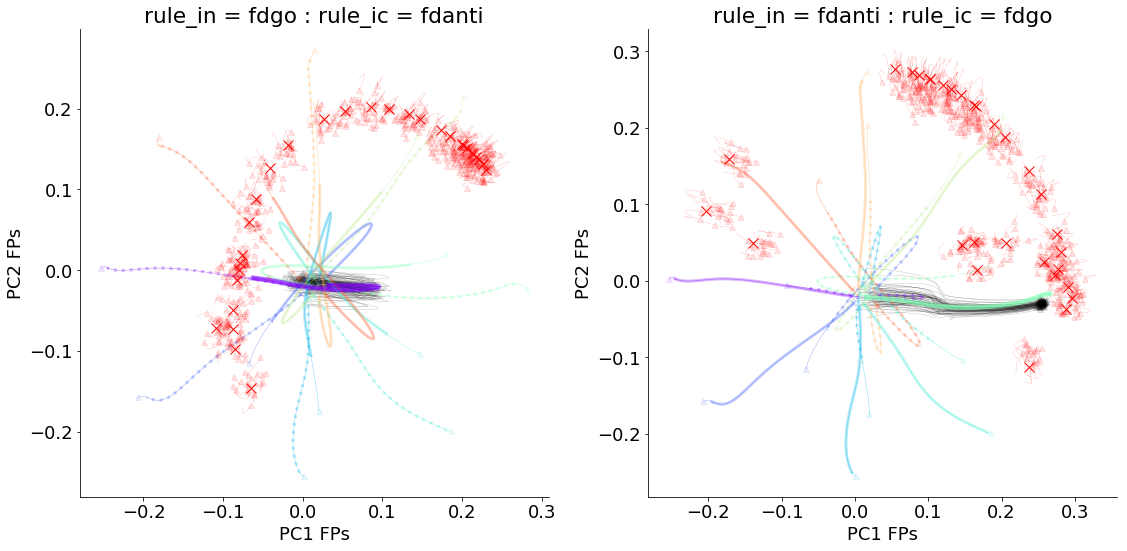

In [53]:
rule_set = ['fdgo','fdanti']
t_num = 0
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='white')

ind_stim_loc = 0
fp_epoch = 'stim1'
opp = [1,0]
fp_t_num = [0, 180]

for ri in range(len(rule_set)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = rule_set[ri]
    rule_ic = rule_set[opp[ri]]
    D_use = make_axes(m_all,'fdanti',fp_epoch)
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = 0.01, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    fp_file = 'tf_fixed_pts_all_init'
    f = os.path.join(m_all,fp_file,rule_in,fp_epoch+'_'+str(round(fp_t_num[ri],2))+'.npz')
#     f = os.path.join(m_all,'golub_fixed_pts',rule_in,fp_epoch+'_'+str(t_num)+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = 30)
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = 0.01,linestyle = '-',n_steps = 10,n_jit = 20)
    
    tit = 'rulein_'+ rule_in + '__ruleic_'+ rule_ic
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel('fdanti'+ ' tdr1')
    plt.ylabel('fdanti'+ ' tdr2')
    
figpath = os.path.join(m,'initXtask',task_list[0]+'_'+task_list[1])
figname = task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
either


NameError: name 'plot_jitter_at_loc' is not defined

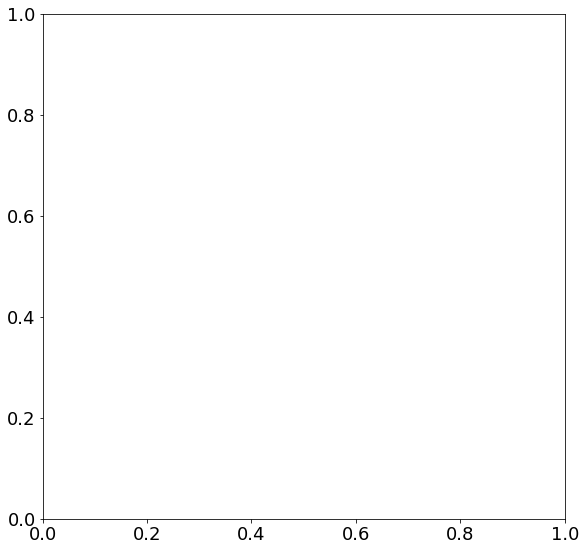

In [132]:
which_net = 'l2w0001'
dir_specific_all = 'crystals/softplus/' + which_net
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

rule_set = ['fdgo','fdanti']
t_num = 0
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='white')

ind_stim_loc = 0
fp_epoch = 'stim1'
opp = [1,0]
fp_t_num = [0, 180]

for ri in range(len(rule_set)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = rule_set[ri]
    rule_ic = rule_set[opp[ri]]
    D_use = make_axes(m_all,'fdanti',fp_epoch)
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = 0.01, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    fp_file = 'tf_fixed_pts_all_init'
    f = os.path.join(m_all,fp_file,rule_in,fp_epoch+'_'+str(round(fp_t_num[ri],2))+'.npz')
#     f = os.path.join(m_all,'golub_fixed_pts',rule_in,fp_epoch+'_'+str(t_num)+'.0.npz')
    _, sorted_fps, fp_inds = make_FP_pcs(f,n_fps = 30)
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
               rand_step_coef = 0.01,linestyle = '-',n_steps = 10,n_jit = 20)
    
    tit = 'rulein_'+ rule_in + '__ruleic_'+ rule_ic
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel('fdanti'+ ' tdr1')
    plt.ylabel('fdanti'+ ' tdr2')
    
figpath = os.path.join(m,'initXtask',task_list[0]+'_'+task_list[1])
figname = task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()